In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
label_index = {"kering": 0, "normal": 1, "berminyak": 2}
index_label = {0: "kering", 1: "normal", 2: "berminyak"}

In [ ]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [ ]:
train_df = create_df("/content/drive/MyDrive/Data_Skin_Type/train")
val_df   = create_df("/content/drive/MyDrive/Data_Skin_Type/val")
test_df  = create_df("/content/drive/MyDrive/Data_Skin_Type/test")

train_df = pd.concat([train_df, val_df, test_df])

In [ ]:
EPOCHS = 11
LR = 0.01
STEP = 15
GAMMA = 0.1
BATCH = 16
OUT_CLASSES = 3
IMG_SIZE = 224
WEIGHT_DECAY = 1e-4

class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))

        return img, label

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [ ]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [ ]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    total = 0
    acc = 0
    for data, target in train_dl:
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    total = 0
    acc = 0

    with torch.no_grad():
        for data, target in val_dl:
            data, target = data.to(device), target.to(device)

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1]))

Epochs 1 train loss 0.18640063956098737 acc 0.34591194968553457 val loss 0.2290029217013352 acc 0.460431654676259
Epochs 2 train loss 0.05826657539215156 acc 0.610062893081761 val loss 0.14307391128951696 acc 0.6115107913669064
Epochs 3 train loss 0.04827060344941104 acc 0.692722371967655 val loss 0.09510413005197649 acc 0.6834532374100719
Epochs 4 train loss 0.04273849425825683 acc 0.7133872416891285 val loss 0.08139442368377027 acc 0.7050359712230215
Epochs 5 train loss 0.03762433851290049 acc 0.7654986522911051 val loss 0.07599274117311985 acc 0.7338129496402878
Epochs 6 train loss 0.0371102506340032 acc 0.7717879604672058 val loss 0.062000585545738826 acc 0.7913669064748201
Epochs 7 train loss 0.03513352812568239 acc 0.7699910152740341 val loss 0.05899479706510365 acc 0.762589928057554
Epochs 8 train loss 0.03307988159258089 acc 0.784366576819407 val loss 0.0482871067180908 acc 0.7985611510791367
Epochs 9 train loss 0.03115100557484931 acc 0.7996406109613656 val loss 0.037722046212

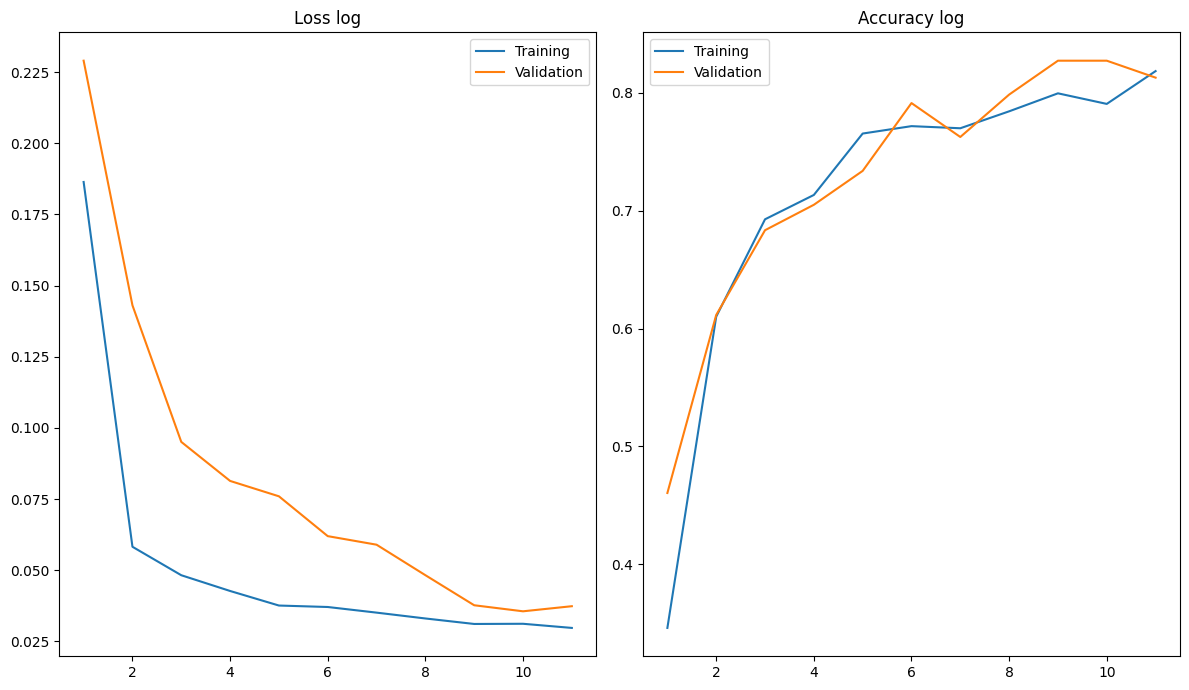

In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

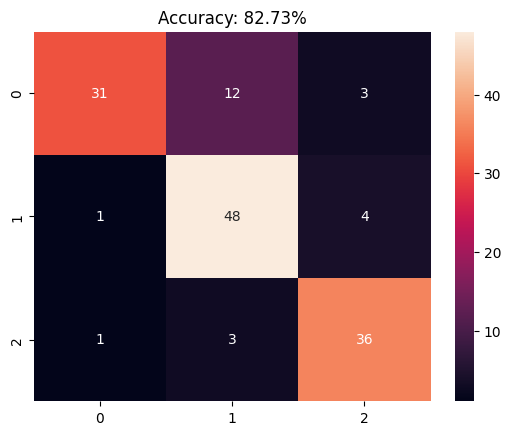

              precision    recall  f1-score   support

           0       0.94      0.67      0.78        46
           1       0.76      0.91      0.83        53
           2       0.84      0.90      0.87        40

    accuracy                           0.83       139
   macro avg       0.85      0.83      0.83       139
weighted avg       0.84      0.83      0.82       139



In [ ]:
def predict_batch(data_loader):
    pred = []
    truth = []

    best_model.eval()
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            out = best_model(data)
            pred += out.argmax(1).cpu().numpy().tolist()
            truth += target.cpu().numpy().tolist()

    return pred, truth

pred, truth = predict_batch(val_dl)

score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)

sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score * 100, 2)))
plt.show()

print(report)


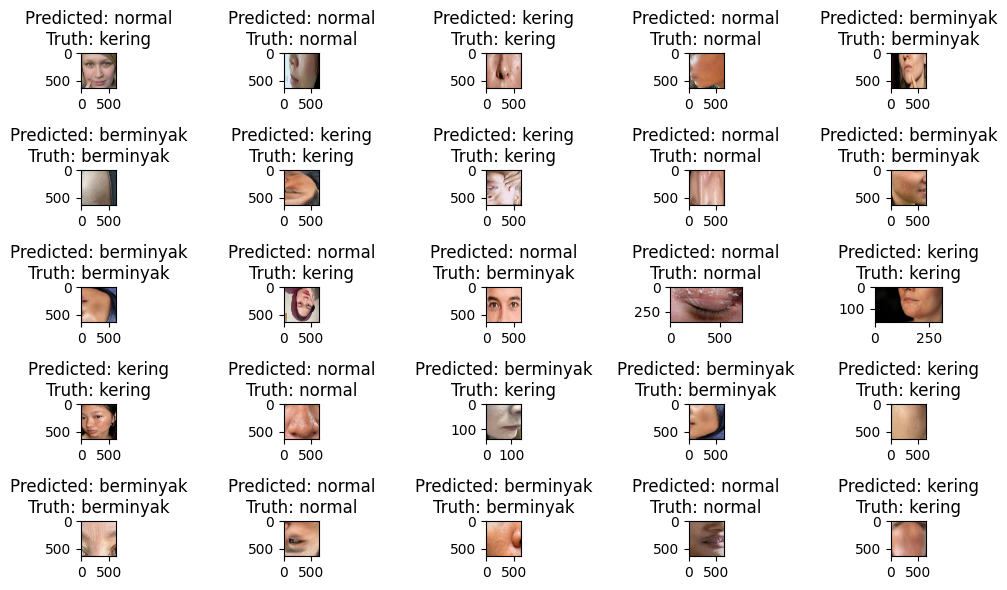

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()

In [ ]:
save_dir = './models'
save_prefix = 'model'

os.makedirs(save_dir, exist_ok=True)

torch.save(best_model.state_dict(), f"{save_dir}/{save_prefix}_best_model_resnet50.pth")

print("Model berhasil disimpan!")

Model berhasil disimpan!


In [ ]:
save_dir = './models'

if os.path.exists(save_dir):
    print(f"Folder '{save_dir}' ada.")
else:
    print(f"Folder '{save_dir}' tidak ditemukan.")

Folder './models' ada.
